In [2]:
# Python specific imports that will make our job easier and our code prettier
from collections import namedtuple
from functools import partial
# import time
# from tqdm.auto import trange, tqdm

# JAX specific imports that we will use to code the logic
import jax.numpy as jnp
import jax.scipy as jsc
from jax.lax import scan
from jax import random
import jax
import matplotlib.pyplot as plt
import jax.random as random
import matplotlib.pyplot as plt
from jax.scipy.linalg import cho_factor, cho_solve
from jax import jit, vmap, lax

In [3]:
def kf(model, observations):
    def body(carry, inputs):
        m, P, loglik = carry
        y = inputs
        Q = model.Pinf - model.A @ model.Pinf @ model.A.T
        m = model.A @ m 
        P = model.A @ P @ model.A.T + Q

        obs_mean = model.H @ m
        S = model.H @ P @ model.H.T + model.R

        K = jsc.linalg.solve(S, model.H @ P, sym_pos=True).T 
        m = m + K @ (y - model.H @ m)
        P = P - K @ S @ K.T

        loglik = -0.5 * jnp.log(2 * jnp.pi) - 0.5 * jnp.log(jnp.linalg.det(S)) \
                  - 0.5 * (y - obs_mean).T @ cho_solve(cho_factor(S), y - obs_mean)

          
        return (m, P, loglik), (m, P, loglik)

    _, (fms, fPs, loglik) = scan(body, (model.m0, model.P0,jnp.array(0.0)), (observations))
    loglik_sum = jnp.sum(loglik)
    return fms, fPs, loglik_sum

def ks(model, ms, Ps):
    def body(carry, inputs):
        m, P = inputs
        sm, sP = carry
        Q = model.Pinf - model.A @ model.Pinf @ model.A.T

        pm = model.A @ m 
        pP = model.A @ P @ model.A.T + Q

        C = jsc.linalg.solve(pP, model.A @ P, sym_pos=True).T  #
        
        sm = m + C @ (sm - pm)
        sP = P + C @ (sP - pP) @ C.T
        return (sm, sP), (sm, sP)

    _, (sms, sPs) = scan(body, (ms[-1], Ps[-1]), (ms[:-1], Ps[:-1]), reverse=True)
    sms = jnp.append(sms, jnp.expand_dims(ms[-1], 0), 0)
    sPs = jnp.append(sPs, jnp.expand_dims(Ps[-1], 0), 0)
    return sms, sPs

def kfs(model, observations):
    m_f, P_f, _ = kf(model, observations)
    return ks(model, m_f, P_f)


In [4]:
class Params:
    def __init__(self, A, H, Pinf, R, x0, P0):
        self.A = A
        self.Pinf = Pinf
        self.H = H
        self.R = R  
        self.m0 = x0  
        self.P0 = P0  

In [5]:
def make_mat32(ell,var,dt):

    lam = 3.0 ** 0.5 / ell
    F = jnp.array([[0.0,       1.0],
                    [-lam ** 2, -2 * lam]])
    L = jnp.array([[0],
                    [1]])
    Qc = jnp.array([[12.0 * 3.0 ** 0.5 / ell ** 3.0 * var]])
    H = jnp.array([[1.0, 0.0]])
    Pinf = jnp.array([[var, 0.0],
                        [0.0, 3.0 * var / ell ** 2.0]])
    
    lam = jnp.sqrt(3.0) / ell
    A = jnp.exp(-dt * lam) * (dt * jnp.array([[lam, 1.0], [-lam**2.0, -lam]]) + jnp.eye(2))
    return A, H, F, L, Qc, H, Pinf



In [163]:
key = random.PRNGKey(0)

x = jnp.linspace(0, 100, 100)
y = (jnp.cos(0.04*x+0.33*jnp.pi) * jnp.sin(0.2*x))  + 0.1 * random.normal(key, (100,))

x_0 = jnp.array([0.,0.])
P_0 = jnp.eye(2)*0.1
R = jnp.array([[0.4]])
u = jnp.ones_like(y)

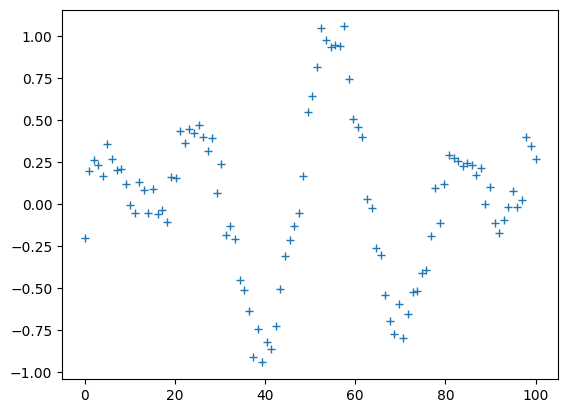

In [164]:
plt.plot(x, y,linestyle='', marker='+')

In [165]:
A, H, F, L, Qc, H, Pinf = make_mat32(6,3.0,1)
R = jnp.array([[0.1]])
model = Params(A, H, Pinf, R, x_0, P_0)

In [166]:
m_kf, P_kf, loglik = kf(model, y)

/var/folders/hz/t56xk_lx0fxb7x_g7tl62kh80000gp/T/ipykernel_53404/407501640.py:12: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  K = jsc.linalg.solve(S, model.H @ P, sym_pos=True).T


In [167]:
m, P_s = kfs(model, y)

/var/folders/hz/t56xk_lx0fxb7x_g7tl62kh80000gp/T/ipykernel_53404/407501640.py:12: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  K = jsc.linalg.solve(S, model.H @ P, sym_pos=True).T
/var/folders/hz/t56xk_lx0fxb7x_g7tl62kh80000gp/T/ipykernel_53404/407501640.py:35: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  C = jsc.linalg.solve(pP, model.A @ P, sym_pos=True).T  #


In [170]:
import gpflow
import numpy as np

X = np.array(x, dtype='float64').reshape(-1, 1)
y = np.array(y, dtype='float64').reshape(-1, 1)
model_gp = gpflow.models.GPR(
    (X, y),
    kernel=gpflow.kernels.Matern32(lengthscales=6.0, variance=3.0)
)
model_gp.likelihood.variance.assign(0.1)

# opt = gpflow.optimizers.Scipy()
# opt.minimize(model.training_loss, model.trainable_variables)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-2.2521789694259944>

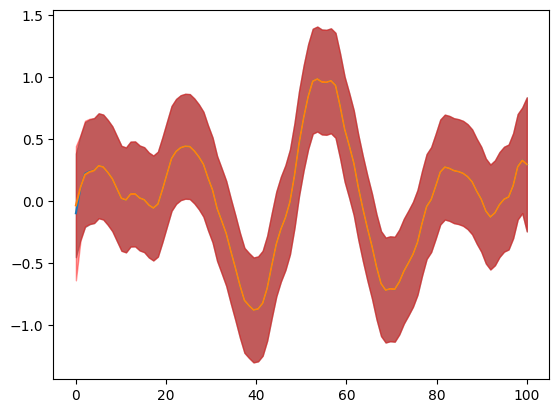

In [172]:
m_gp, v_gp = model.predict_f(X)

lower = m[:,0] - 2*jnp.sqrt(P_s[:,0,0])
upper = m[:,0] + 2*jnp.sqrt(P_s[:,0,0])

l_gp = m_gp - 2*np.sqrt(v_gp)
u_gp = m_gp + 2*np.sqrt(v_gp)

plt.plot(x, m_gp)
plt.plot(x, m[:,0])
plt.fill_between(x, lower, upper, alpha=0.8, color='grey')
plt.fill_between(np.squeeze(X), np.squeeze(l_gp.numpy()), np.squeeze(u_gp.numpy()), alpha=0.4, color='red')

In [187]:

opt = gpflow.optimizers.Scipy()
opt.minimize(model_gp.training_loss, model_gp.trainable_variables)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -50.81072294071902
        x: [ 1.130e+01 -9.887e-01 -4.829e+00]
      nit: 14
      jac: [-1.281e-05  6.854e-05  6.194e-05]
     nfev: 20
     njev: 20
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [188]:
model_gp

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.31631
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,11.3012
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00797


In [176]:
import jax
import jax.numpy as jnp
import optax

num_epochs = 8500

# Define your model and loss function here
# ...

# Define your optimizer
learning_rate = 0.001
optimizer = optax.adam(learning_rate)

# Initialize your model parameters and optimizer state
params = {'ell': jnp.array(1.0), 'var': jnp.array(1.0),'sigma': jnp.array(1.0)}
opt_state = optimizer.init(params)

def loss(params, y, u):
    A, H, F, L, Qc, H, Pinf = make_mat32(params['ell'],params['var'], 1.0)
    
    model = Params(A, H, Pinf, params['sigma'], x_0, P_0)
    m_kf, P_kf, loglik = kf(model, y)
    return -loglik

# Define your training step function
@jax.jit
def train_step(params, opt_state, y, u):
    # Compute the loss and gradients
    loss_value, grads = jax.value_and_grad(loss)(params, y, u)

    # Update the optimizer state
    updates, opt_state = optimizer.update(grads, opt_state)

    # Update the model parameters
    params = optax.apply_updates(params, updates)

    return params, opt_state, loss_value

# Define your training loop
for epoch in range(num_epochs):
    # Execute a training step
    params, opt_state, value = train_step(params, opt_state, y, u)

    # Print the loss at the end of each epoch
    print(f"Epoch {epoch+1}, Loss: {value:.4f}")

/var/folders/hz/t56xk_lx0fxb7x_g7tl62kh80000gp/T/ipykernel_53404/407501640.py:12: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  K = jsc.linalg.solve(S, model.H @ P, sym_pos=True).T


Epoch 1, Loss: 126.7982
Epoch 2, Loss: 126.7427
Epoch 3, Loss: 126.6871
Epoch 4, Loss: 126.6314
Epoch 5, Loss: 126.5758
Epoch 6, Loss: 126.5200
Epoch 7, Loss: 126.4642
Epoch 8, Loss: 126.4084
Epoch 9, Loss: 126.3525
Epoch 10, Loss: 126.2966
Epoch 11, Loss: 126.2406
Epoch 12, Loss: 126.1846
Epoch 13, Loss: 126.1285
Epoch 14, Loss: 126.0723
Epoch 15, Loss: 126.0161
Epoch 16, Loss: 125.9599
Epoch 17, Loss: 125.9036
Epoch 18, Loss: 125.8472
Epoch 19, Loss: 125.7908
Epoch 20, Loss: 125.7342
Epoch 21, Loss: 125.6777
Epoch 22, Loss: 125.6211
Epoch 23, Loss: 125.5644
Epoch 24, Loss: 125.5077
Epoch 25, Loss: 125.4509
Epoch 26, Loss: 125.3940
Epoch 27, Loss: 125.3371
Epoch 28, Loss: 125.2801
Epoch 29, Loss: 125.2230
Epoch 30, Loss: 125.1659
Epoch 31, Loss: 125.1087
Epoch 32, Loss: 125.0515
Epoch 33, Loss: 124.9941
Epoch 34, Loss: 124.9367
Epoch 35, Loss: 124.8793
Epoch 36, Loss: 124.8218
Epoch 37, Loss: 124.7642
Epoch 38, Loss: 124.7065
Epoch 39, Loss: 124.6488
Epoch 40, Loss: 124.5910
Epoch 41,

In [177]:
A, H, F, L, Qc, H, Pinf = make_mat32(params['ell'],params['var'], 1.0)
model = Params(A, H, Pinf, params['sigma'], x_0, P_0)

m, P_s = kfs(model, y)

/var/folders/hz/t56xk_lx0fxb7x_g7tl62kh80000gp/T/ipykernel_53404/407501640.py:12: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  K = jsc.linalg.solve(S, model.H @ P, sym_pos=True).T
/var/folders/hz/t56xk_lx0fxb7x_g7tl62kh80000gp/T/ipykernel_53404/407501640.py:35: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  C = jsc.linalg.solve(pP, model.A @ P, sym_pos=True).T  #


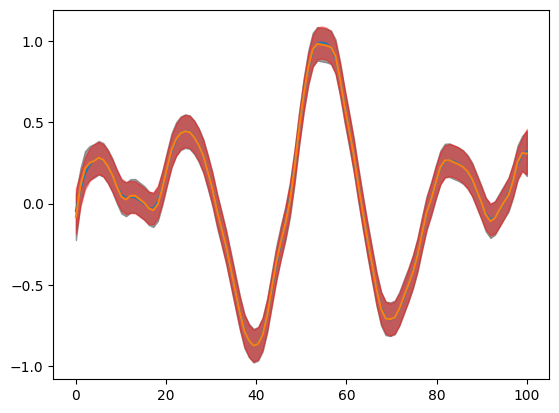

In [189]:
m_gp, v_gp = model_gp.predict_f(X)

lower = m[:,0] - 2*jnp.sqrt(P_s[:,0,0])
upper = m[:,0] + 2*jnp.sqrt(P_s[:,0,0])

l_gp = m_gp - 2*np.sqrt(v_gp)
u_gp = m_gp + 2*np.sqrt(v_gp)

plt.plot(x, m_gp)
plt.plot(x, m[:,0])
plt.fill_between(x, lower, upper, alpha=0.8, color='grey')
plt.fill_between(np.squeeze(X), np.squeeze(l_gp.numpy()), np.squeeze(u_gp.numpy()), alpha=0.4, color='red')